In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Initilizations


In [6]:
RANDOM_SIZE = 100
IMG_DIM = 28
BATCH_SIZE = 100
EPSILON = 1e-3
LEARNING_RATE = 0.0002
LABELS = 10

# Generator

In [5]:
z = keras.Input((RANDOM_SIZE,),dtype=tf.float32)
y_gen =  keras.Input((labels,))
concat = keras.layers.concatenate([z,y_gen],axis=1)
layer_1 = keras.layers.Dense(264,activation=tf.nn.leaky_relu)(concat)
layer_2 = keras.layers.Dense(IMG_DIM*IMG_DIM,activation=tf.nn.sigmoid)(layer_1)
fake_img = keras.layers.Reshape((IMG_DIM,IMG_DIM))(layer_2)

generator = keras.Model(inputs=[z,y_gen],outputs=fake_img)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 264)          29304       concatenate[0][0]            

# Discriminator

In [7]:
x = keras.Input((IMG_DIM,IMG_DIM))
y = keras.Input((LABELS,))
flatten = keras.layers.Flatten()(x)
concate = keras.layers.concatenate([flatten,y],axis=1)
layer_1 = keras.layers.Dense(264,activation=tf.nn.relu)(concate)
pred = keras.layers.Dense(1,activation=tf.nn.sigmoid)(layer_1)

discriminator = keras.Model(inputs=[x,y],outputs=pred)
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           flatten[0][0]                    
                                                                 input_4[0][0]              

# Model

In [8]:
class CGAN(keras.Model):
  
  def __init__(self,generator,discriminator,**kwargs):
    super(CGAN, self).__init__(**kwargs)
    self.generator = generator
    self.discriminator = discriminator
    self.generator_loss_tracker = keras.metrics.Mean(name="generator_loss")
    self.discriminator_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

  @property
  def metrics(self):
    return [
            self.generator_loss_tracker,
            self.discriminator_loss_tracker
    ]

  @tf.function
  def train_step(self,data):

    z = np.random.uniform(-1,1,(BATCH_SIZE,RANDOM_SIZE))
    x, y = data
    with tf.GradientTape() as disctape:
      with tf.GradientTape() as gentape:
        
        fake_img = self.generator([z,y])
        fake_pred = self.discriminator([fake_img,y])
        gen_loss = -tf.reduce_mean(tf.math.log(fake_pred+EPSILON))

      real_pred = self.discriminator([x,y])
      disc_loss = -tf.reduce_mean(tf.math.log(1-fake_pred+EPSILON)+tf.math.log(real_pred+EPSILON))

    disc_grads = disctape.gradient(disc_loss,self.discriminator.trainable_weights)
    gen_grads = gentape.gradient(gen_loss,self.generator.trainable_weights)

    self.optimizer.apply_gradients(zip(disc_grads,self.discriminator.trainable_weights))
    self.optimizer.apply_gradients(zip(gen_grads,self.generator.trainable_weights))

    self.generator_loss_tracker.update_state(gen_loss)
    self.discriminator_loss_tracker.update_state(disc_loss)

    return {
        "generator_loss" : self.generator_loss_tracker.result(),
        "discriminator_loss": self.discriminator_loss_tracker.result()
    }


In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

mnist_fashion = np.concatenate([x_train,x_test],axis=0)
mnist_fashion_x = mnist_fashion.astype('float64')/255
mnist_y = np.concatenate([y_train,y_test],axis=0)
mnist_fashion_y = tf.keras.utils.to_categorical(mnist_y,LABELS)

(mnist_fashion_x.shape , mnist_fashion_y.shape)

4431872/4422102 [==============================] - 0s 0us/step


((70000, 28, 28), (70000, 10))

In [11]:
model = CGAN(generator,discriminator)
model.compile(optimizer=tf.optimizers.Adam(LEARNING_RATE))
model.fit(mnist_fashion_x,mnist_fashion_y,epochs=50, batch_size=BATCH_SIZE)

Epoch 1/50
700/700 [==============================] - 10s 13ms/step - generator_loss: 3.7832 - discriminator_loss: 0.1685
Epoch 2/50
700/700 [==============================] - 9s 13ms/step - generator_loss: 4.3071 - discriminator_loss: 0.1754
Epoch 3/50
700/700 [==============================] - 9s 13ms/step - generator_loss: 3.5495 - discriminator_loss: 0.2243
Epoch 4/50
700/700 [==============================] - 9s 13ms/step - generator_loss: 2.9926 - discriminator_loss: 0.3063
Epoch 5/50
700/700 [==============================] - 9s 13ms/step - generator_loss: 2.6506 - discriminator_loss: 0.3075
Epoch 6/50
700/700 [==============================] - 9s 13ms/step - generator_loss: 2.2737 - discriminator_loss: 0.4133
Epoch 7/50
700/700 [==============================] - 9s 13ms/step - generator_loss: 2.2260 - discriminator_loss: 0.4682
Epoch 8/50
700/700 [==============================] - 9s 13ms/step - generator_loss: 2.3909 - discriminator_loss: 0.4713
Epoch 9/50
700/700 [===========

In [15]:
def create(item='t-shirt',x=5,y=5,figsize=(10,10)):
  import matplotlib.pyplot as plt
  
  feauture_map = {
      't-shirt' : 0,
      'trouser' : 1,
      'pullover': 2,
      'dress' : 3,
      'coat': 4,
      'sandal': 5, 
      'shirt':6,
      'sneaker':7,
      'bag': 8,
      'ankle bot':9
  }
  tf.keras.utils.to_categorical(feauture_map[item],LABELS)
  
  imgs = model.generator([np.random.uniform(-1,1,size=(x*y,RANDOM_SIZE)),np.tile(tf.keras.utils.to_categorical(feauture_map[item],LABELS),(x*y,1))])
  imgs = imgs.numpy()
  figure = np.zeros(shape=(x*IMG_DIM,y*IMG_DIM),dtype=np.float32)
  for i in range(x):
    for j in range(y):
      figure[i*IMG_DIM:(i+1)*IMG_DIM,j*IMG_DIM:(j+1)*IMG_DIM] = imgs[i*y+j]
  
  plt.figure(figsize=figsize)
  plt.imshow(figure,cmap="Greys_r")



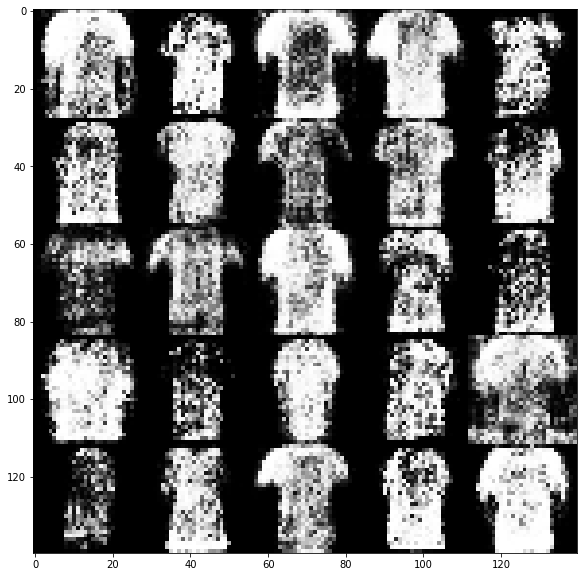

In [17]:
create('t-shirt')

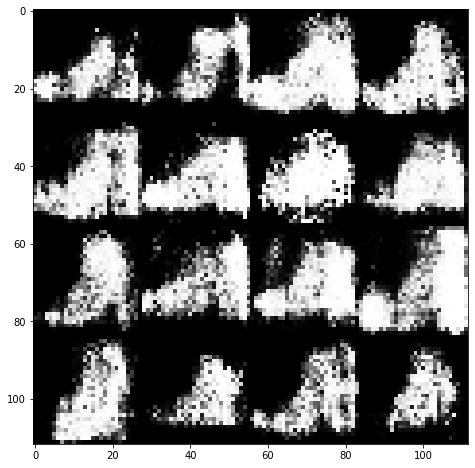

In [21]:
create('ankle bot',4,4,(8,8))

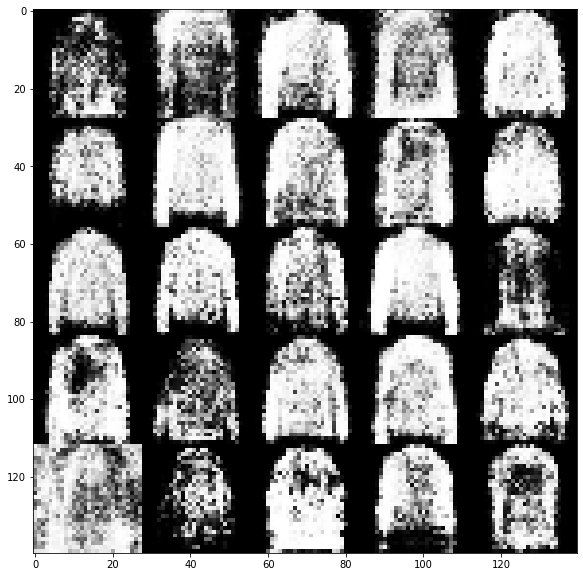

In [20]:
create('coat')